# Breast-96-Samples.R as a Notebook 

rMATS 3.2.5 was run on controlled access RNASeq files retrieved experiments stored in the Sequence Read Archive with controlled access managed by dbGaP.   The data were generated under the Gene Tissue Expression.

## rMATS RNASeq-MATS.py produces 10 different output types which get assembled into as type junction ID by sample ID matrices

### Alternative Splice Site Types are: (se, a3ss, a5ss, mxe, ri)

 This is input as ARGV1 into variable 'astype'

  * Skipped Exon events (se),
  * Alternative 3' splice site (a3ss),
  * Alternative 5' splice site (a5ss),
  * Mutually exclusive exon (mxe),
  * and retention intron (ri)

### There are two different kinds of junction counts

  * jc = junction counts - reads that cross the junction
  * jcec = junction counts plus reads on the target (such as included exon

### And the count type -- there are 5 types

  * inclusion levels (percent spliced in)
  * included junction counts (ijc)
  * skipped junction counts (sjc)
  * inclusion length (inclen)
  * skipped length (skiplen)

### function: fit_iso_tissue 

fit_iso_tissue expects the following input:

  * the tissue of interest (SMSTD) 
  * an ordered_merged_rmats -- which will be ordered to fit the count matrix
  * count matrix (inc or ijc & sjc merged)
  * splice type (a3ss, a5ss, mxe, ri or se)
  * junction_count type (jc or jcec)
  * count type (inc or the merged ijc,sjc)
  
### reordering to match annotations between count matrix and annotation matrix

Common problem is to match specifically the rows of an annotation matrix with the columns of a count matrix
`match` is the function that gives the re-ordering index required to accomplish this


## **NOTE**:

We assume that you have cloned the analysis repository and have `cd` into the parent directory. Before starting with the analysis make sure you have first completed the dependencies set up by following the instructions described in the **`dependencies/README.md`** document. All paths defined in this Notebook are relative to the parent directory (repository). Please close this Notebook and start again by following the above guidelines if you have not completed the aforementioned steps.

## rMATS-final-merged
the rmats-nf NextFlow was executed and the results released here:

## Loading dependencies

In [1]:
library(limma)
library(multtest)
library(Biobase)
library(edgeR)
library(tibble)
install.packages('R.utils')
library(R.utils)

Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following object is masked from ‘package:limma’:

    plotMA

The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which, which.max, which.min

Loading required package: Biobase
Welcome to Bio

## Modeling

This analysis uses edgeR.  From the documentation, it is important to note that normalization takes the form of correction factors that enter into the statistical model. Such correction factors are usually computed internally by edgeR functions, but it is also possible for a user to supply them. The correction factors may take the form of scaling factors for the library sizes, such as computed by calcNormFactors, which are then used to compute the effective library sizes. 

Alternatively, gene-specific correction factors can be entered into the glm functions of edgeR as offsets. In the latter case, the offset matrix will be assumed to account for all normalization issues, including sequencing depth and RNA composition.

Note that normalization in edgeR is model-based, and the original read counts are not themselves transformed. This means that users should not transform the read counts in any way before inputing them to edgeR. For example, users should not enter RPKM or FPKM val- ues to edgeR in place of read counts. Such quantities will prevent edgeR from correctly estimating the mean-variance relationship in the data, which is a crucial to the statistical strategies underlying edgeR. Similarly, users should not add artificial values to the counts before inputing them to edgeR.

edgeR is not designed to work with estimated expression levels, for example as might be output by Cufflinks. 
edgeR can work with expected counts as output by RSEM, but raw counts are still preferred. 

As instructed by the software, we are using the raw counts as provided by rMATS.  The raw counts we are using in the model are `ijc` and `sjc`, the sample specific raw read counts as they align to the junctions of the `included exon (ijc)` and the junctions of the `excluded or skipped exon (sjc)` respectively.



In [2]:
ijc.iso.counts.mem <- data.table::fread("../data/rmats_final.se.jc.ijc.txt.gz") 
sjc.iso.counts.mem <- data.table::fread("../data/rmats_final.se.jc.sjc.txt.gz") 

meta.data<-read.csv('../data/SraRunTable.noCram.noExome.noWGS.totalRNA.txt',header=TRUE, stringsAsFactors=FALSE)
head(ijc.iso.counts.mem)
head(sjc.iso.counts.mem)
head(meta.data)

ID,SRR1068788,SRR1068808,SRR1068832,SRR1068855,SRR1068880,SRR1068929,SRR1068953,SRR1068977,SRR1068999,⋯,SRR821573,SRR821581,SRR821602,SRR821626,SRR821653,SRR821690,SRR821715,SRR823967,SRR823991,SRR824015
<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,0,0,0,0,1,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
2,26,247,103,620,494,145,145,139,697,⋯,151,32,62,48,963,25,196,76,72,61
3,1,0,1,0,0,0,1,1,2,⋯,2,1,0,1,3,0,1,0,0,0
4,0,1,1,2,0,0,1,0,2,⋯,0,0,0,0,1,0,0,0,0,0
5,3,0,2,3,6,1,1,1,5,⋯,3,2,0,1,6,0,2,0,0,0
6,2,1,2,5,6,1,1,0,5,⋯,1,1,0,0,4,0,1,0,0,0


ID,SRR1068788,SRR1068808,SRR1068832,SRR1068855,SRR1068880,SRR1068929,SRR1068953,SRR1068977,SRR1068999,⋯,SRR821573,SRR821581,SRR821602,SRR821626,SRR821653,SRR821690,SRR821715,SRR823967,SRR823991,SRR824015
<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,2,0,1,3,6,1,0,0,3,⋯,1,1,0,0,3,0,1,0,0,0
2,0,0,0,1,0,0,1,0,0,⋯,0,0,0,0,0,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
4,0,0,0,1,0,0,0,0,1,⋯,0,0,0,0,2,0,1,0,0,0
5,0,5,3,8,4,0,3,0,3,⋯,9,3,1,2,3,0,1,0,1,0
6,11,119,36,284,207,60,63,43,295,⋯,52,13,14,9,338,8,63,25,20,18


,Run,analyte_type,Assay.Type,AvgSpotLen,Bases,BioProject,BioSample,biospecimen_repository,biospecimen_repository_sample_id,body_site,⋯,data_type..run.,product_part_number..exp.,product_part_number..run.,sample_barcode..exp.,sample_barcode..run.,is_technical_control,target_set..exp.,primary_disease..exp.,secondary_accessions..run.,Alignment_Provider..run.
,<chr>,<chr>,<chr>,<int>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<lgl>,<chr>,<chr>,<lgl>
1,SRR2911715,RNA,RNA-Seq,150,3852895500,PRJNA244100,SAMN04216864,Cloud Testing,HG00103,Lymphoblastoid cell line,⋯,,,,NA,NA,,NA,,,NA
2,SRR2911716,RNA,RNA-Seq,150,4885577400,PRJNA244100,SAMN04216866,Cloud Testing,HG00154,Lymphoblastoid cell line,⋯,,,,NA,NA,,NA,,,NA
3,SRR2911718,RNA,RNA-Seq,150,2690545500,PRJNA244100,SAMN04216863,Cloud Testing,NA18910,Lymphoblastoid cell line,⋯,,,,NA,NA,,NA,,,NA
4,SRR2911719,RNA,RNA-Seq,150,2699599350,PRJNA244100,SAMN04216865,Cloud Testing,NA19200,Lymphoblastoid cell line,⋯,,,,NA,NA,,NA,,,NA
5,SRR2911720,RNA,RNA-Seq,152,4300467752,PRJNA244100,SAMN04216865,Cloud Testing,NA19200,Lymphoblastoid cell line,⋯,,,,NA,NA,,NA,,,NA
6,SRR2911717,RNA,RNA-Seq,150,2666546700,PRJNA244100,SAMN04216863,Cloud Testing,NA18910,Lymphoblastoid cell line,⋯,,,,NA,NA,,NA,,,NA


## Synchronize metadata samples with ijc and sjc samples

Keep only the runs that are in the ijc count list (assuming ijc and sjc are the same).  As well, name the rows with the junction id column and then make the matrix just about the counts.

In [3]:
#dimensions before we make the changes.
dim(ijc.iso.counts.mem)
dim(sjc.iso.counts.mem)
dim(meta.data)

# the sample names are in the columns of both the ijc and the sjc matrices, these matrices have the identical column order)
keep.meta.data <- meta.data$Run %in% colnames(ijc.iso.counts.mem)
table(keep.meta.data)
reduced.meta.data <- meta.data[keep.meta.data==TRUE,]

[1] 42611  8674

[1] 42611  8674

[1] 9784   79

keep.meta.data
FALSE  TRUE 
 1111  8673 

## Construct the ijc and sjc as data matrices
The Junction ID is encoded in the first column of the matrix.  We need to both preserve it (and it is unique) as well as remove it so we may do our calculations.

In [4]:
# preserve junction id as rowname
rownames(ijc.iso.counts.mem) <- ijc.iso.counts.mem$ID
rownames(sjc.iso.counts.mem) <- sjc.iso.counts.mem$ID

# and remove the id to have a data matrix
ijc.iso.counts.mem  <- ijc.iso.counts.mem[,-1]
sjc.iso.counts.mem  <- sjc.iso.counts.mem[,-1]

dim(ijc.iso.counts.mem)
dim(sjc.iso.counts.mem)
dim(reduced.meta.data)

[1] 42611  8673

[1] 42611  8673

[1] 8673   79

## Order ijc and sjc columns in the same order as the metadata Run order

Using tibble library, we can rearrange the columns as the column name.  

In [5]:
meta.data.run.names  <- as.character(reduced.meta.data$Run)
ijc.iso.counts.mem2  <- as_tibble(ijc.iso.counts.mem)
sjc.iso.counts.mem2  <- as_tibble(sjc.iso.counts.mem)

ijc.iso.counts.mem2  <- ijc.iso.counts.mem2[,c(meta.data.run.names)]
sjc.iso.counts.mem2  <- sjc.iso.counts.mem2[,c(meta.data.run.names)]

Remove samples that match '11IL0' from the ijc, sjc and metadata files

In [6]:
keep.meta.data <- (!grepl('11ILO',reduced.meta.data$Sample.Name))
table(keep.meta.data)
ijc.iso.counts.mem2 <-ijc.iso.counts.mem2 [                    ,keep.meta.data==TRUE]
sjc.iso.counts.mem2 <-sjc.iso.counts.mem2 [                    ,keep.meta.data==TRUE]
reduced.meta.data   <-reduced.meta.data   [keep.meta.data==TRUE,                    ]
dim(ijc.iso.counts.mem2)
dim(sjc.iso.counts.mem2)

keep.meta.data
FALSE  TRUE 
   12  8661 

[1] 42611  8661

[1] 42611  8661

### and focus on a single tissue

In [7]:
tissue <- reduced.meta.data$body_site %in% 'Breast - Mammary Tissue'
table(tissue)

ijc.iso.counts.mem2 <-ijc.iso.counts.mem2 [                    ,tissue==TRUE]
sjc.iso.counts.mem2 <-sjc.iso.counts.mem2 [                    ,tissue==TRUE]
reduced.meta.data   <-reduced.meta.data   [tissue==TRUE,                    ]
dim(ijc.iso.counts.mem2)
dim(sjc.iso.counts.mem2)

tissue
FALSE  TRUE 
 8470   191 

[1] 42611   191

[1] 42611   191

## Modeling 



In [8]:
groups=c(paste0(reduced.meta.data$sex,'-sjc'),paste0(reduced.meta.data$sex,'-ijc'))
table(groups)

groups
female-ijc female-sjc   male-ijc   male-sjc 
        81         81        110        110 

separate the matrices counts into male and female

In [9]:
ijc.counts.male   <- ijc.iso.counts.mem2 [,reduced.meta.data$sex=='male']

ijc.counts.female <- ijc.iso.counts.mem2 [,reduced.meta.data$sex=='female']

sjc.counts.male   <- sjc.iso.counts.mem2 [,reduced.meta.data$sex=='male']

sjc.counts.female <- sjc.iso.counts.mem2 [,reduced.meta.data$sex=='female']


make the matrix, combining now the male and female counts - achieving a rearrangement count columns included counts male, female, followed by skiped counts male female
rownames remain the junction id's which we will use later to resolve the genes from which these isoforms come.

In [10]:
ijc.counts.mat           <- cbind(ijc.counts.male, ijc.counts.female)
sjc.counts.mat           <- cbind(sjc.counts.male, sjc.counts.female)
counts.mat               <- cbind(ijc.counts.male, ijc.counts.female, sjc.counts.male, sjc.counts.female)

rownames(sjc.counts.mat) <- rownames(sjc.iso.counts.mem)
rownames(ijc.counts.mat) <- rownames(ijc.iso.counts.mem2)
rownames(counts.mat)     <- rownames(ijc.iso.counts.mem)

## isoform
Create an isoform, this will be used in the modeling.  The sum is equal to the total number of samples.   For each sample, they will be represented in each of the forms, so that the modeling could occur, it does make the assumption that there are at least 2 isoforms.   One that has representation as an isoform with includes reads on a specific junction, and one that is an isoform that excludes that particular junction.   This is an over simplification of what is an isoform.   But a useful technique for modeling for differential expression.

In [11]:
isoform<-c(rep(1,ncol(ijc.counts.male)+ncol(ijc.counts.female)),rep(0,ncol(sjc.counts.male)+ncol(sjc.counts.female)))

## sex
Encode then in the matrix the sex values.   This will also be used for making the differential analysis model.  

In [12]:
sex<-c(rep(1,ncol(ijc.counts.male)),rep(0,ncol(ijc.counts.female)),rep(1,ncol(sjc.counts.male)),rep(0,ncol(sjc.counts.female)))

## block - accounting for duplicate correlation

The counts ijc and sjc are from the same sample and are two different measure that are tightly correlated.   We want to account for that.  In order to do this, we create a counts matrix, that keeps the inclusion junction counts (male and then female) separated by the skipped junction counts (male and then female). We calculate the normalization factors by just using one of the counts, so that we don't duplicate it -- this is done by first making the matrix wide -- so that the library count information is done just one per row.   And then repeating these normalization factors in such a way to allow them to be accounted for with the duplicateCorrelation function, which is made to do so when block is defined, which we have done so, matching exactly the design as stated here.  We have two counts closely related within one sample.

In [13]:
block<-c(rep(1,c(ncol(ijc.counts.male)+ncol(ijc.counts.female))), rep(2, c(ncol(sjc.counts.male)+ncol(sjc.counts.female))))

In [14]:
block

[1] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 [38] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 [75] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
[112] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
[149] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
[186] 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
[223] 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
[260] 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
[297] 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
[334] 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
[371] 2 2 2 2 2 2 2 2 2 2 2 2

# removing zero rows 
Voom adds 0.05 so that the typical log2 error does not occur -- we can safely cut off values < 1.  Lets plot just to see.
The ideal here is to keep only those rows which have non-zero values


In [15]:
rowDistribution <- rowSums(counts.mat)
names(rowDistribution) <- rownames(counts.mat)
index <- order(rowDistribution, decreasing=FALSE)
y <- rowDistribution[index]
y.gt.1 <- y[y > 1]
y.gt.5 <- y[y > 5]
sum(y<=1)
sum(y<=5)
max(y.gt.1)
min(y.gt.1)
max(y.gt.5)
min(y.gt.5)
median(y)
median(y.gt.1)
median(y.gt.5)
log2y.gt.1 <- log2(y.gt.1)
log2y.gt.5 <- log2(y.gt.5)

[1] 1528

[1] 2679

[1] 2549921

[1] 2

[1] 2549921

[1] 6

[1] 2734

[1] 3048

[1] 3300

In [16]:
tail(log2y.gt.1)
tail(names(log2y.gt.1))
log2.df <- data.frame(log2y<-factor(log2y.gt.1))
colnames(log2.df) <- 'log2y'
tail(log2.df)

39543    37555    39541    15257    13422    15259 
20.74274 20.77791 20.79610 20.80039 20.86141 21.28202

[1] "39543" "37555" "39541" "15257" "13422" "15259"

,log2y
,<fct>
39543,20.7427395209616
37555,20.777905421868
39541,20.7961045839211
15257,20.8003864827797
13422,20.8614050055411
15259,21.2820211204578


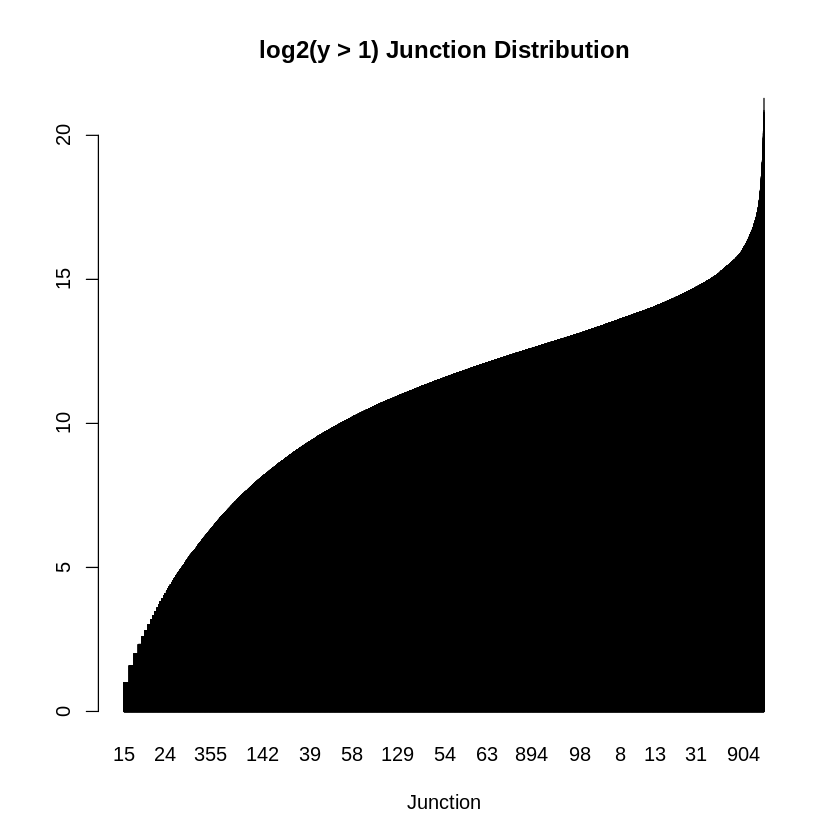

In [17]:
library(ggplot2)

barplot(log2y.gt.1, main="log2(y > 1) Junction Distribution",
   xlab="Junction")


In [18]:
pdf ("../pdf/log2.y.gt.1.rowcnts.pdf")
barplot(log2y.gt.1, main="log2(y > 1) Junction Distribution",
   xlab="Junction")
dev.off()

png 
  2

# Eliminate zero rows

As shown above -- there are over 2000 zero rows.  These are junctions without counts in either ijc or sjc.  We eliminate them.

In [19]:
# we will plot what we have 
keep.rows <- y > 1
table(keep.rows)

dim(counts.mat)

isoform   <-isoform   
sex       <-sex       
block     <-block     
counts.mat<-counts.mat[keep.rows==TRUE,]

dim(counts.mat)
table(block)
table(isoform)
table(sex)

keep.rows
FALSE  TRUE 
 1528 41083 

[1] 42611   382

[1] 41083   382

block
  1   2 
191 191 

isoform
  0   1 
191 191 

sex
  0   1 
162 220 

finally we are able to perform our analysis.

In [20]:
is.matrix(counts.mat)
counts.mat.dm <- data.matrix(counts.mat)
is.matrix(counts.mat.dm)
counts.mat <- counts.mat.dm

[1] FALSE

[1] TRUE

make an EDGR DGEList for our differential analysis

In [21]:
y <- edgeR::DGEList(counts=counts.mat,
                    group =block)


Repeated column names found in count matrix


## accounting for duplicate correlation

The counts ijc and sjc are from the same sample and are two different measure that are tightly correlated.   We want to account for that.  In order to do this, we create a counts matrix, that keeps the inclusion junction counts (male and then female) separated by the skipped junction counts (male and then female). We calculate the normalization factors by just using one of the counts, so that we don't duplicate it -- this is done by first making the matrix wide -- so that the library count information is done just one per row.   And then repeating these normalization factors in such a way to allow them to be accounted for with the duplicateCorrelation function, which is made to do so when block is defined, which we have done so, matching exactly the design as stated here.  We have two counts closely related within one sample.

In [22]:
counts.isoform.mat =  cbind(counts.mat[,isoform==1] + counts.mat[,isoform==0])
y.isoform          <- DGEList(counts=counts.isoform.mat)
y.isoform          <- calcNormFactors(y.isoform)
y                  <- DGEList(counts=counts.mat)
y                  <- calcNormFactors(y)

dim   (y.isoform$counts)
length(y.isoform$samples$norm.factors)
dim   (y$counts)
length(y$samples$norm.factors)

Repeated column names found in count matrix


[1] 41083   191

[1] 191

[1] 41083   382

[1] 382

In [23]:
y$samples$norm.factors=rep(y.isoform$samples$norm.factors,2)

Here we create the design matrix for our linear model, we are interested in seeing separately the impact of sex and isoform as well as their interaction factor.

In [24]:
design <- model.matrix(~sex+isoform+sex*isoform)

In [25]:
table(design[,'sex'])
table(design[,'isoform'])
table(design[,'sex:isoform'])


  0   1 
162 220 


  0   1 
191 191 


  0   1 
272 110 

## voom
mean variance plot of the raw counts and the DGEList should be the same

### voom raw counts

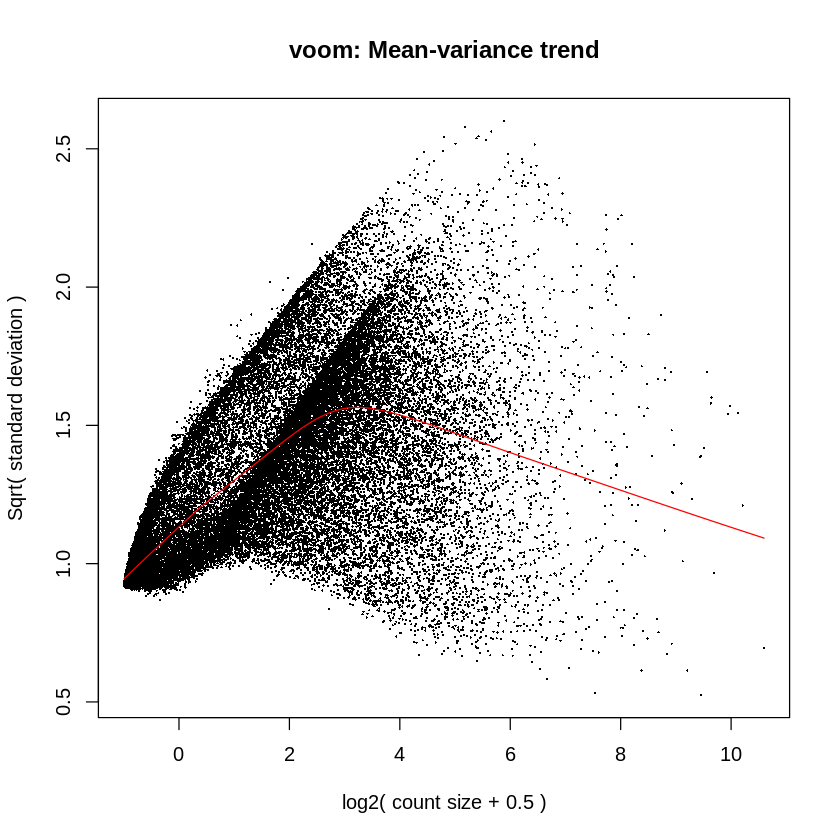

In [26]:
voom.raw.counts.mat <- voom(counts.mat,plot=TRUE, save.plot=TRUE)

### voom DGEList

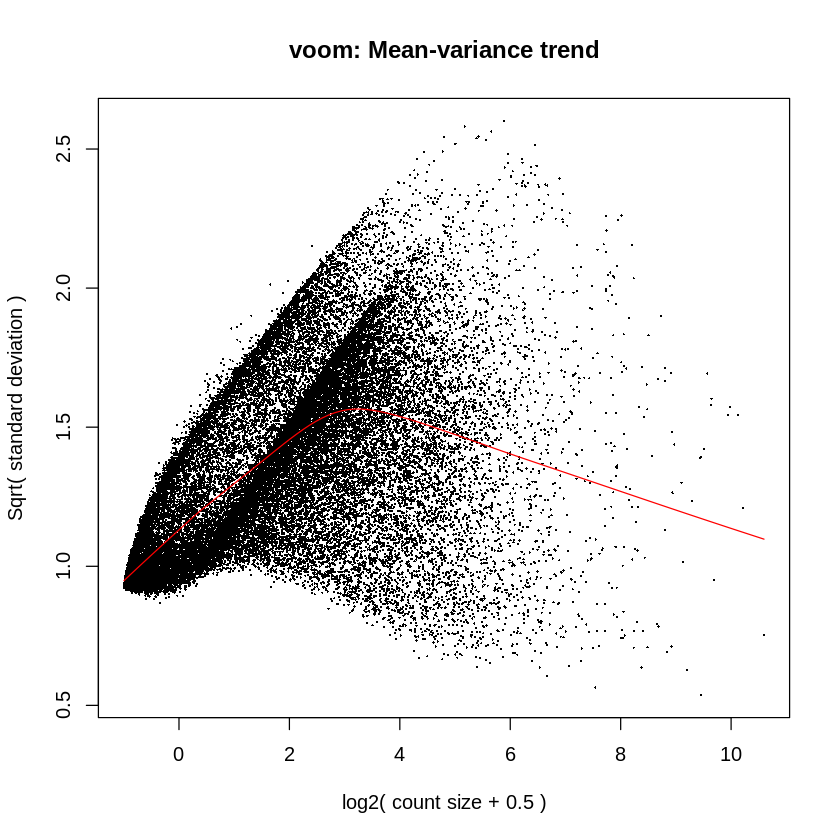

In [27]:
voom.y.DGEList <- voom(y, plot=TRUE, save.plot=TRUE)

# duplicateCorrelation
Using the block design, and noting that likely, on average, there are at least 2 junctions for a skipped exon event, if we analyze the other events, such as mutually exclusive exons, the number of junctions will be different, we can model the multiple features.  There may be an argument for a different way of proceeding with this modeling.  For example, one could model in the design model itself this feature or argue that the feature is accounted for in the isoform definition.   Warnings occur in the underlying modeling program used here, a gamma generalized linear model by Fisher Scoring with Identity link.  statmod::glmgam.fit.  This function implements a modified Fisher scoring algorithm for generalized linear models, similar to the Levenberg-Marquardt algorithm for nonlinear least squares. The Levenberg-Marquardt modification checks for a reduction in the deviance at each step, and avoids the possibility of divergence. The result is a very secure algorithm that converges for almost all datasets.

In [28]:
dup.corr = duplicateCorrelation(voom.y.DGEList,ndups=2,block=block)

Warning message in glmgam.fit(dx, dy, coef.start = start, tol = tol, maxit = maxit, :
“Too much damping - convergence tolerance not achievable”

In [30]:
head(dup.corr)


$consensus.correlation
[1] 0.8670122

$cor
[1] 0.8670122

$atanh.correlations
    [1] -2.038830e-03 -1.674670e-03  1.131346e+00  5.991704e-01  1.313950e+00
    [6]  6.072517e-01  1.814579e-01  1.408089e+00  1.421141e+00  2.507713e+00
   [11]  2.090677e+00  2.244718e+00  2.453070e+00  2.496784e+00  2.395312e+00
   [16]  2.242224e+00  1.710532e+00  1.426328e+00  1.052041e+00  1.416309e+00
   [21]  1.445068e+00  3.115384e-01 -3.878916e-03  1.638137e+00  2.721596e+00
   [26]  2.545523e+00  6.702430e-01  2.571544e+00 -2.637523e-03  4.261469e-02
   [31]  2.568407e+00  2.277072e+00  2.921975e+00  2.324085e+00  1.612313e+00
   [36]  2.299180e+00  1.161462e+00  1.269574e+00  8.453223e-01  7.616289e-01
   [41]  1.068490e+00  8.506617e-01  1.060648e+00  1.169577e+00  1.280542e+00
   [46]  1.226239e+00  2.120781e+00  1.538266e+00  1.027458e+00  1.615049e+00
   [51]  1.754349e+00  1.312643e+00  1.084247e+00  1.149645e+00  5.309838e-01
   [56]  2.162556e+00  1.701744e+00  7.222408e-01  1.955281e+00  7.857611e-01
   [61]  8.355545e-01  6.705712e-01  1.351389e+00  1.344157e+00  1.363179e+00
   [66]  1.351389e+00  1.177317e+00  6.531533e-01  8.446329e-01  1.929823e-01
   [71]  5.953043e-01  9.188775e-01  7.599319e-01  7.880531e-01  2.383834e-01
   [76]  7.633445e-01  9.272416e-01  8.810857e-01 -6.438496e-04  1.095052e+00
   [81]  8.522478e-01  8.452700e-01  1.867068e+00  1.684118e+00  1.858040e+00
   [86]  9.436124e-01  1.727597e+00  1.167584e+00  1.103054e+00  1.362959e+00
   [91]  2.301497e+00  1.182466e+00  7.326107e-01  1.460329e+00  1.455208e+00
   [96]  9.874992e-01  1.865886e-01  2.177258e+00  1.570814e+00  1.098766e+00
  [101]  1.041175e+00  6.541482e-01  1.000241e+00  8.435625e-01  1.258184e+00
  [106]  1.269741e+00  9.982792e-01  1.261575e+00  2.144548e+00  1.108797e+00
  [111]  1.254297e+00  4.586581e-01  2.038002e-01  1.420238e+00  1.560149e+00
  [116]  1.427100e+00  1.259620e+00  1.597459e+00  6.596281e-01  7.046549e-01
  [121]  5.272232e-01  6.636995e-01  1.429812e+00  1.971550e+00  1.136047e-01
  [126]  2.089951e+00  6.349113e-02  1.416499e+00  1.089707e+00  9.051242e-01
  [131]  8.434689e-01  1.069521e+00  6.467834e-01  8.458692e-01  1.126393e+00
  [136]  9.283174e-01  1.122110e+00  7.660201e-01  8.204239e-01  4.072713e-01
  [141]  5.787211e-01  2.697788e-01  4.298815e-01  8.797538e-01  3.627778e-01
  [146]  2.220097e+00  1.281711e+00  3.902534e-01  6.812317e-01  5.215951e-01
  [151]  1.908914e+00  1.659117e+00  7.528411e-01  1.203499e+00  1.356619e+00
  [156]  5.736670e-02  2.686507e-02  1.358525e+00  1.464771e+00  1.296324e+00
  [161]  1.214364e+00  1.264261e+00  9.841619e-01  1.228488e+00  9.356869e-01
  [166]  1.230495e+00  1.235513e+00  5.813900e-01  1.169971e+00  1.325143e+00
  [171]  1.441367e+00  8.518530e-01  1.460329e+00  1.460329e+00  1.813021e+00
  [176]  1.422662e+00  1.768015e+00  8.308960e-01  2.384012e+00  8.532669e-01
  [181]  2.312031e+00  9.075731e-01  1.132308e+00  7.350056e-01  2.109091e+00
  [186]  5.514150e-05  4.388117e-01  1.317317e-01  7.815335e-01  9.982569e-02
  [191]  2.626576e+00  1.151413e+00  2.333512e+00  1.067811e+00  1.689739e+00
  [196]  9.414272e-01  1.460329e+00  1.195325e+00  1.697393e+00  6.232658e-01
  [201]  5.932710e-01  1.432547e+00  2.733129e-01  4.727583e-01  1.863172e+00
  [206]  1.258594e+00  1.438517e+00  2.050501e+00  9.714270e-01  1.140455e+00
  [211]  1.054634e+00  2.128109e+00  1.266922e+00  2.099060e+00  6.051098e-01
  [216]  1.118327e+00  1.853367e+00  1.929478e+00  2.345187e+00  7.876349e-01
  [221]  1.939357e+00  1.550993e+00  2.101144e+00  1.753281e+00  2.034215e+00
  [226]  1.777786e+00  2.252306e+00  2.572452e+00  1.947203e+00  1.129896e+00
  [231]  1.853364e+00  1.501601e-02  9.089419e-01  1.595927e+00  1.720118e+00
  [236]  1.371631e+00  1.875943e+00  1.788748e+00  1.621246e+00  1.577264e+00
  [241]  2.220417e+00  2.046940e+00  1.839300e+00  1.264884e+00  5.884680e-01
  [246]  1.149067e+00  1.123331e+00  2.175229e+00  2.443172e+00  2.302069e+00
  [251]  2.348488e+00 

## voom 

We have now obtained the model for the correlation between the two features of ijc and sjc to be used in the model.
we will use the just now calculated correlation event.   Our counts data will now be converted to log2 counts.

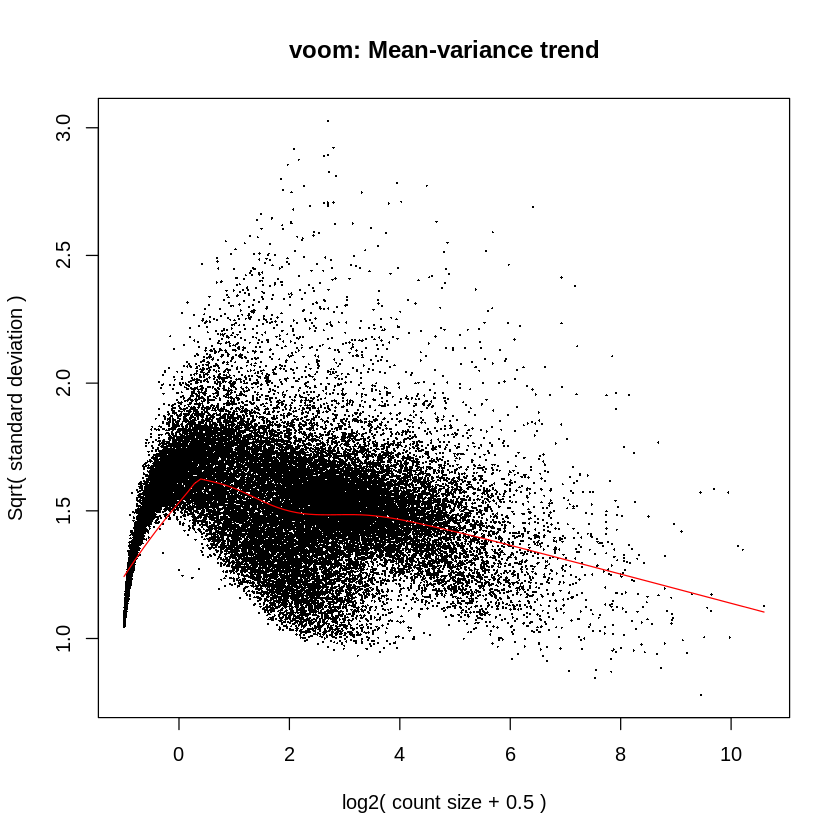

In [31]:
v.with.block <- voom(counts.mat, design=design, block=block, correlation = dup.corr$consensus.correlation, plot=TRUE, save.plot=TRUE)

Let us see the results without the blocks in the design.

In [ ]:
v <- voom(counts.mat, design=design, plot=TRUE, save.plot=TRUE)

## Bayes fit

done with out block, as it does not to appear to make a significant difference.   


In [ ]:
fit <- lmFit(v$E, design)
fit <- eBayes(fit)
sex.res         = topTable(fit, coef='sex',         number=nrow(counts.mat))
sex.isoform.res = topTable(fit, coef='sex:isoform', number=nrow(counts.mat))
isoform.res     = topTable(fit, coef='isoform',     number=nrow(counts.mat))

In [ ]:
fit.corr <- lmFit(v$E, design=design, block=block, correlation=dup.corr$consensus.correlation)
fit.corr <- eBayes(fit.corr)
sex.res.corr         = topTable(fit.corr, coef='sex',         number=nrow(counts.mat))
sex.isoform.res.corr = topTable(fit.corr, coef='sex:isoform', number=nrow(counts.mat))
isoform.res.corr     = topTable(fit.corr, coef='isoform',     number=nrow(counts.mat))

In [ ]:
head(sex.res)
head(sex.res.corr)

In [ ]:
head(isoform.res)
head(isoform.res.corr)


In [ ]:
head(sex.isoform.res)
head(sex.isoform.res.corr)

In [ ]:

filename      = paste(paste('../data/BreastMammaryTissue',collapse='.'),'.sex.se.txt',sep='')
genesFilename = paste(paste('../data/BreastMammaryTissue',collapse='.'),'.sex.all_genes.txt',sep='')

sex.res.pVal.0.05.logFC.gt.1.5 <- sex.res$adj.P.Val <= 0.05 & abs(sex.res$logFC) > 1.5
table(sex.res.pVal.0.05.logFC.gt.1.5)

sex.res.refined <- sex.res[sex.res.pVal.0.05.logFC.gt.1.5==TRUE,]

write.table(sex.res.refined,          file=filename,      row.names = T, col.names = T, quote = F)
write.table(rownames(sex.res.refined),file=genesFilename, row.names = T, col.names = T, quote = F)


## Ontologizer


In [ ]:
meta.data       <-read.table('../data/fromGTF.SE.txt',sep='\t',header=TRUE)
all.genes       <-read.table('../data/BreastMammaryTissue.sex.all_genes.txt')
de.tab          <-read.table('../data/BreastMammaryTissue.sex.se.txt')

de.tab.with.meta<-merge(de.tab,meta.data,by.x='row.names',by.y='ID')


In [ ]:
dim(de.tab.with.meta)
head(de.tab.with.meta)

## subset
Based upon our significant results, keep only those subsetted genes


In [ ]:
subset <- meta.data$ID %in% all.genes[,1]
table(subset)
significant.genes <- meta.data$geneSymbol[subset==TRUE]
length(significant.genes)

## Ontologizer

Use the ontologizer to show the significance of the subsetted genes against the backdrop of all the genes within the experiment set.
rMATS stores this in the fromGTF folder in the geneSymbol category

In [ ]:
setwd('/mnt/shared/gcp-user/session_data/sbas/jupyter')
getwd()

In [ ]:
write.table(meta.data$geneSymbol,       '../data/universe.txt',quote = F,row.names = F,col.names = F)
write.table(de.tab.with.meta$geneSymbol,'../data/gene_set.txt',quote = F,row.names = F,col.names = F)

In [ ]:
system('java -jar ../../ontologizer/Ontologizer.jar -g ../../ontologizer/go.obo -a ../../ontologizer/goa_human.gaf -s ../data/gene_set.txt -p ../data/universe.txt -c Term-For-Term -m Benjamini-Hochberg -n -o ../data')

## Metadata

For replicability and reproducibility purposes, we also print the following metadata:

1. Checksums of **'artefacts'**, files generated during the analysis and stored in the folder directory **`data`**
2. List of environment metadata, dependencies, versions of libraries using `utils::sessionInfo()` and [`devtools::session_info()`](https://devtools.r-lib.org/reference/session_info.html)

### 1. Checksums with the sha256 algorithm

In [ ]:
notebookid   = "Breast-96-Samples"

message("Generating sha256 checksums of the artefacts in the `..data/` directory .. ")
system(paste0("cd ../data && find . -type f -exec sha256sum {} \\;  >  ../metadata/", notebookid, "_sha256sums.txt"), intern = TRUE)
message("Done!\n")

data.table::fread(paste0("../metadata/", notebookid, "_sha256sums.txt"), header = FALSE, col.names = c("sha256sum", "file"))

### 2. Libraries metadata

In [ ]:
dev_session_info   <- devtools::session_info()
utils_session_info <- utils::sessionInfo()

message("Saving `devtools::session_info()` objects in ../metadata/devtools_session_info.rds  ..")
saveRDS(dev_session_info, file = paste0("../metadata/", notebookid, "_devtools_session_info.rds"))
message("Done!\n")

message("Saving `utils::sessionInfo()` objects in ../metadata/utils_session_info.rds  ..")
saveRDS(utils_session_info, file = paste0("../metadata/", notebookid ,"_utils_info.rds"))
message("Done!\n")

dev_session_info$platform
dev_session_info$packages[dev_session_info$packages$attached==TRUE, ]